In [2]:
%load_ext autoreload
%autoreload 2

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import datetime
import copy
import json

import sys
sys.path.append('../../')

from data.dataloader import Covid19IndiaLoader
from data.processing import get_data
from data.processing.whatifs import scale_up_acc_to_testing

from models.seir import SEIRHD, SEIR_Testing, SEIR_Movement, SEIR_Movement_Testing

from main.seir.fitting import single_fitting_cycle, get_variable_param_ranges
from main.seir.uncertainty import MCUncertainty
from main.seir.optimiser import Optimiser
from main.seir.forecast import get_forecast, create_region_csv, create_all_csvs, write_csv, forecast_all_trials, trials_to_df, scale_up_testing_and_forecast
from main.seir.sensitivity import gridsearch_single_param, calculate_sensitivity_and_plot

from utils.create_report import create_report
from utils.loss import Loss_Calculator
from utils.enums import Columns
from utils.enums.columns import *

from viz import plot_forecast

In [4]:
predictions_dict = {}

## Select Districts to fit on

In [5]:
state, district = ('Maharashtra', 'Mumbai')

## Params

In [6]:
date_of_interest = '2020-07-31'
forecast_days = 37
now = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
folder = str(now)
ktrials = 10

## Perform M1 and M2 fits

Performing m1 fit ..
../../cache/dataframes_ts_27072020_tracker.pkl


/home/users/bhardwaj/env_covid/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


93 93
Smoothing 7358 recovered between 2020-05-28 and 2020-04-26 (32) days in a weighted-mag manner
Smoothing 3139 recovered between 2020-06-14 and 2020-04-26 (49) days in a weighted-mag manner
Smoothing 916 recovered between 2020-06-15 and 2020-04-26 (50) days in a weighted-mag manner
Smoothing 2432 recovered between 2020-06-23 and 2020-06-15 (8) days in a weighted-mag manner
Smoothing 2141 recovered between 2020-06-24 and 2020-06-15 (9) days in a weighted-mag manner
Smoothing 5900 recovered between 2020-07-01 and 2020-05-28 (34) days in a weighted-mag manner
Smoothing 917 deceased between 2020-06-15 and 2020-04-26 (50) days in a weighted-mag manner

splitting data ..
splitting data ..
train
          date        state district  total_infected  hospitalised  \
55 2020-06-23  Maharashtra   Mumbai    68627.714286  22628.142857   
56 2020-06-24  Maharashtra   Mumbai    69902.428571  22600.000000   
57 2020-06-25  Maharashtra   Mumbai    71195.428571  22639.142857   
58 2020-06-26  Mahara

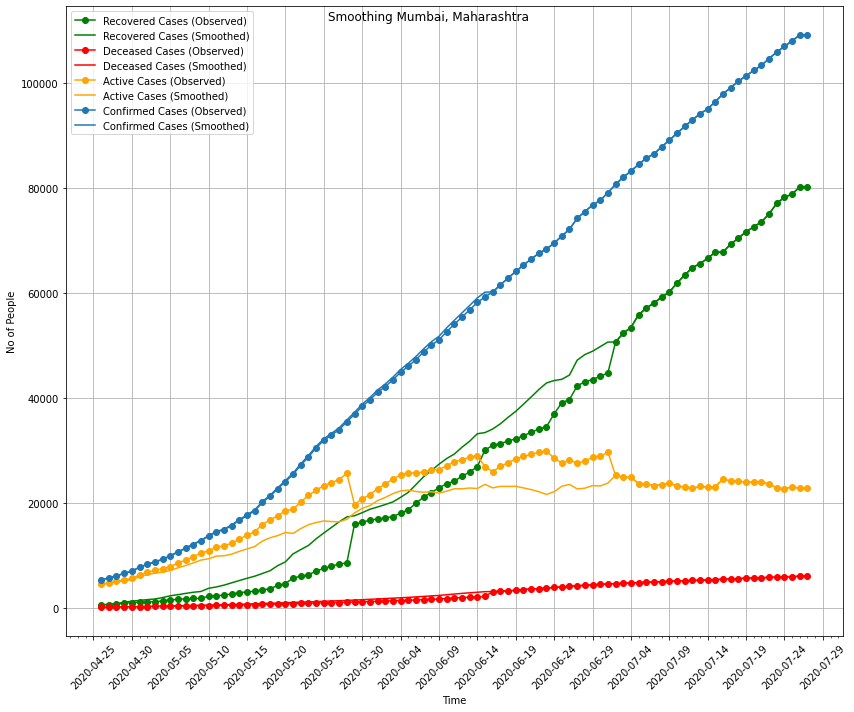

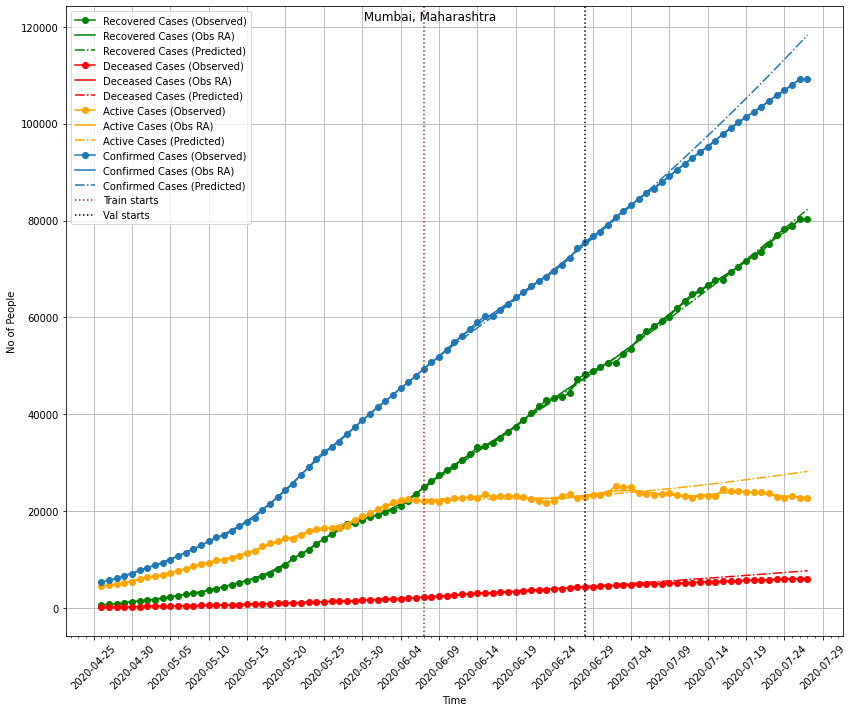

In [12]:
predictions_dict['m1'] = single_fitting_cycle(
    state, district, data_from_tracker=True, granular_data=False, filename=None, #Data
    model=SEIRHD, #Choose Model and Ranges
    train_period=21, val_period=30, num_evals=1000, initialisation='intermediate', #Optimisation related parameters
    which_compartments=['total_infected', 'hospitalised', 'recovered', 'deceased'], #Compartments to Apply Loss on 
    smooth_jump=True)
# predictions_dict['m2'] = single_fitting_cycle(
#     state, district, train_period=21, val_period=0, num_evals=1000,
#     data_from_tracker=False, initialisation='intermediate', model=SEIRHD, 
#     smooth_jump=True,
#     which_compartments=['hospitalised', 'total_infected', 'deceased', 'recovered'])

predictions_dict['state'] = state
predictions_dict['dist'] = district
predictions_dict['fitting_date'] = datetime.datetime.now().strftime("%Y-%m-%d")
predictions_dict['datasource'] = 'covid19api' if predictions_dict['m1']['data_from_tracker'] else 'municipality'
predictions_dict['variable_param_ranges'] = predictions_dict['m1']['variable_param_ranges']

## Loss DataFrames

### M1 Loss DataFrame

In [13]:
predictions_dict['m1']['df_loss']

,train,val
total_infected,0.662969,2.56193
hospitalised,1.99641,8.94628
recovered,1.30412,1.08011
deceased,1.98115,13.3556


### M2 Loss DataFrame

In [ ]:
predictions_dict['m2']['df_loss']

## Plot Forecasts

In [ ]:
# for region in predictions_dict.keys():
#     predictions_dict[region]['m2']['df_forecast'] = get_forecast(predictions_dict[region], days=forecast_days)
#     predictions_dict[region]['m2']['forecast'] = plot_forecast(predictions_dict[region], region, both_forecasts=False, error_bars=True, days=forecast_days)
    
#     predictions, losses, params = get_all_trials(predictions_dict[region], train_fit='m1')
#     predictions_dict[region]['m1']['params'] = params
#     predictions_dict[region]['m1']['losses'] = losses
#     predictions_dict[region]['m1']['predictions'] = predictions
#     predictions_dict[region]['m1']['all_trials'] = trials_to_df(predictions, losses, params)

#     predictions, losses, params = get_all_trials(predictions_dict[region], train_fit='m2')
#     predictions_dict[region]['m2']['params'] = params
#     predictions_dict[region]['m2']['losses'] = losses
#     predictions_dict[region]['m2']['predictions'] = predictions
#     predictions_dict[region]['m2']['all_trials'] = trials_to_df(predictions, losses, params)
#     kforecasts = plot_trials(
#         predictions_dict[region],
#         train_fit='m2',
#         predictions=predictions, 
#         losses=losses, params=params, 
#         k=ktrials,
#         which_compartments=[Columns.confirmed, Columns.active])
#     predictions_dict[region]['m2']['forecast_confirmed_topk'] = kforecasts[Columns.confirmed]
#     predictions_dict[region]['m2']['forecast_active_topk'] = kforecasts[Columns.active]

## Uncertainty

In [ ]:
region_dict = predictions_dict[('Maharashtra', 'Mumbai')]
uncertainty = MCUncertainty(region_dict, date_of_interest)

In [ ]:
uncertainty.beta

## Create Report


In [ ]:
for region in predictions_dict.keys():
    create_report(predictions_dict[region], ROOT_DIR=output_folder)
    predictions_dict[region]['m1']['all_trials'].to_csv(os.path.join(output_folder, 'm1-trials.csv'))
#     predictions_dict[region]['m2']['all_trials'].to_csv(os.path.join(output_folder, 'm2-trials.csv'))

## Create and Save Output CSV

In [ ]:
df_output = create_all_csvs(predictions_dict, icu_fraction=0.02)

In [ ]:
write_csv(df_output, filename=os.path.join(output_folder, f'output-{t}.csv'))

In [17]:
trials_processed = forecast_all_trials(predictions_dict, train_fit='m1', forecast_days=forecast_days)
predictions_dict['m1']['trials_processed'] = trials_processed
predictions_dict['m1']['all_trials'] = trials_to_df(trials_processed, column=Columns.confirmed)

8it [00:00, 79.29it/s]

getting forecasts ..


1000it [00:12, 78.48it/s]


In [18]:
predictions_dict['m1']['all_trials'].to_csv('m1-trials.csv')

In [28]:
losses_array = predictions_dict['m1']['all_trials']['loss']

In [29]:
params_fulldict = predictions_dict['m1']['all_trials']

In [33]:
beta = 0.367
R0means=[]
R0stdevs=[]
Pfatalmeans=[]
Pfatalstdevs=[]
Tinfmeans=[]
Tinfstdevs=[]
Tincmeans=[]
Tincstdevs=[]
Trsmeans=[]
Trsstdevs=[]
Trfmeans=[]
Trfstdevs=[]

Loss_norm=0
R0sum=0
R0sqsum=0
Pfatal_sum=0
Pfatal_sqsum=0
Tinf_sum=0
Tinf_sqsum=0
Tinc_sum=0
Tinc_sqsum=0
Trs_sum=0
Trs_sqsum=0
Trf_sum=0
Trf_sqsum=0

tempdict = params_fulldict
templosses = losses_array
for k in range(len(tempdict)):
    Loss_norm += np.exp(-beta*templosses[k])
    R0sum += np.exp(-beta*templosses[k])*tempdict['lockdown_R0'][k]
    R0sqsum += np.exp(-beta*templosses[k])*tempdict['lockdown_R0'][k]**2
    Pfatal_sum += np.exp(-beta*templosses[k])*tempdict['P_fatal'][k]
    Pfatal_sqsum += np.exp(-beta*templosses[k])*tempdict['P_fatal'][k]**2
    Tinf_sum += np.exp(-beta*templosses[k])*tempdict['T_inf'][k]
    Tinf_sqsum += np.exp(-beta*templosses[k])*tempdict['T_inf'][k]**2
    Tinc_sum += np.exp(-beta*templosses[k])*tempdict['T_inc'][k]
    Tinc_sqsum += np.exp(-beta*templosses[k])*tempdict['T_inc'][k]**2
    Trs_sum += np.exp(-beta*templosses[k])*tempdict['T_recov_severe'][k]
    Trs_sqsum += np.exp(-beta*templosses[k])*tempdict['T_recov_severe'][k]**2
    Trf_sum += np.exp(-beta*templosses[k])*tempdict['T_recov_fatal'][k]
    Trf_sqsum += np.exp(-beta*templosses[k])*tempdict['T_recov_fatal'][k]**2
R0means.append(R0sum/Loss_norm)
R0stdevs.append(np.sqrt(R0sqsum/Loss_norm-(R0sum/Loss_norm)**2))
Pfatalmeans.append(Pfatal_sum/Loss_norm)
Pfatalstdevs.append(np.sqrt(Pfatal_sqsum/Loss_norm-(Pfatal_sum/Loss_norm)**2))
Tinfmeans.append(Tinf_sum/Loss_norm)
Tinfstdevs.append(np.sqrt(Tinf_sqsum/Loss_norm-(Tinf_sum/Loss_norm)**2))
Tincmeans.append(Tinc_sum/Loss_norm)
Tincstdevs.append(np.sqrt(Tinc_sqsum/Loss_norm-(Tinc_sum/Loss_norm)**2))
Trsmeans.append(Trs_sum/Loss_norm)
Trsstdevs.append(np.sqrt(Trs_sqsum/Loss_norm-(Trs_sum/Loss_norm)**2))
Trfmeans.append(Trf_sum/Loss_norm)
Trfstdevs.append(np.sqrt(Trf_sqsum/Loss_norm-(Trf_sum/Loss_norm)**2))

param_mean=[R0means, Pfatalmeans, Tinfmeans, Tincmeans, Trsmeans, Trfmeans]
param_stdev=[R0stdevs, Pfatalstdevs, Tinfstdevs, Tincstdevs, Trsstdevs, Trfstdevs]


In [34]:
param_mean

[[1.1036916353970891],
 [0.08461995434289825],
 [3.5063977808717537],
 [4.750909487387452],
 [19.215949046845605],
 [19.659289509707794]]

In [35]:
param_stdev

[[0.014093212732279203],
 [0.01965579031477212],
 [0.12192128373848109],
 [0.163355049674619],
 [1.770252279550626],
 [5.657666969651705]]